

### Задание для курсового проекта

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:
1. Соревнование заканчивается 10.01.21
2. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту")
ссылку на ноутбук в github или public kaggle notebook.
3. Необходимо получить R2 > 0.6 на Private Leaderboard.
4. Укажите свой ник на kaggle 


Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.
____________
Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. По возможности добавлять графики, описывающие данные (около 3-5)
4. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
5. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
6. Весь проект должен быть в одном скрипте (файл ipynb).
7. При использовании статистик (среднее, медиана и т.д.) в качестве признаков,
лучше считать их на трейне, и потом на валидационных и тестовых данных не считать 
статистики заново, а брать их с трейна.
8. Проект должен полностью отрабатывать за разумное время (не больше 10 минут),
поэтому в финальный вариант лучше не включать GridSearch с перебором 
большого количества сочетаний параметров. 

**План занятия**
* [Загрузка данных](#load)
* [1. EDA](#eda)
* [2. Обработка выбросов](#outlier)
* [3. Обработка пропусков](#nan)
* [4. Построение новых признаков](#feature)
* [5. Отбор признаков](#feature_selection)
* [6. Разбиение на train и test](#split)
* [7. Построение модели](#modeling)
* [8. Прогнозирование на тестовом датасете](#prediction)

**Подключение библиотек и скриптов**

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2, mean_squared_error as mse
from sklearn.model_selection import KFold, GridSearchCV
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
matplotlib.rcParams.update({'font.size': 14})

In [7]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [8]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2 # подсчитываем память потребляемую изначальным датасетом
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns: # проходимся по всем колонкам
        col_type = df[col].dtype  # узнаем тип колонки
        
        if col_type != object:
            c_min = df[col].min() # смотрим минимальное значение признака
            c_max = df[col].max() # смотрим максимальное значение признака
            if str(col_type)[:3] == 'int':  # if int
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max: # сравниваем с int8
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max: # сравниваем с int16 и.т.д.
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else: # если был тип object, то меняем его тип на пандасовский тип 'category', на нем разные агрегации данных работают в разы быстрее
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2  # считаем сколько теперь у нас занято памяти
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))  # и выводим статистику
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

**Пути к директориям и файлам**

In [9]:
TRAIN_DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/SKLearn_Project_Prediction/train.csv'
TEST_DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/SKLearn_Project_Prediction/test.csv'

### Загрузка данных <a class='anchor' id='load'>

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [10]:
train_df = pd.read_csv('train.csv')
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [11]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [12]:
test_df = pd.read_csv('test.csv')
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [13]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте', test_df.shape[0])

Строк в трейне: 10000
Строк в тесте 5000


In [14]:
train_df.shape[1] - 1 == test_df.shape[1]

True

### Приведение типов

In [15]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [16]:
#train_df['Id'] = train_df['Id'].astype(str)
#train_df['DistrictId'] = train_df['DistrictId'].astype(str)

## 1. EDA  <a class='anchor' id='eda'>
Делаем EDA для:
- Исправления выбросов
- Заполнения NaN
- Идей для генерации новых фич

**Целевая переменная**

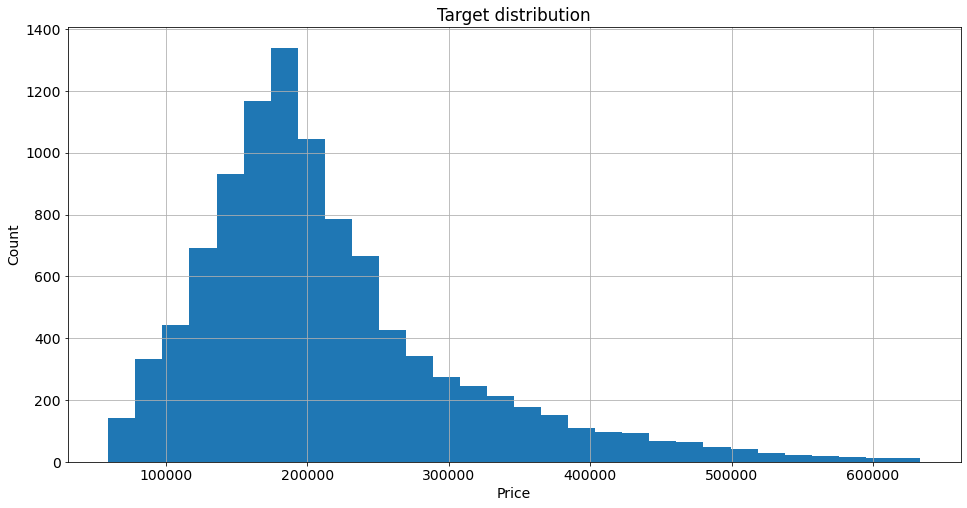

In [17]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

**Количественные переменные**

In [18]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


**Номинативные переменные**

In [19]:
train_df.select_dtypes(include='object').columns.tolist()

['Ecology_2', 'Ecology_3', 'Shops_2']

In [20]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
196      1
117      1
205      1
199      1
207      1
Name: DistrictId, Length: 205, dtype: int64

In [21]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [22]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [23]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

### 2. Обработка выбросов  <a class='anchor' id='outlier'>


In [24]:
test_df1=test_df.copy()

**Rooms**

In [25]:
test_df1['Rooms'].value_counts()

2.0     2030
1.0     1769
3.0     1099
4.0       90
5.0        7
0.0        2
6.0        2
17.0       1
Name: Rooms, dtype: int64

In [26]:
test_df1['Rooms_outlier'] = 0
test_df1.loc[(test_df1['Rooms'] == 0) | (test_df1['Rooms'] >= 6), 'Rooms_outlier'] = 1
test_df1.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Rooms_outlier
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B,0
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A,0
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,0
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B,0
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B,0


In [27]:
test_df1.loc[test_df1['Rooms'] == 0, 'Rooms'] = 1
test_df1.loc[test_df1['Rooms'] >= 6, 'Rooms'] = test_df1['Rooms'].median()

Дополню колонку Rooms_outlier другими неадекватными значениями. Крайние площади выбрал исходя из объявлений на ЦИАНе. К выбросам применю методKNN, но это уже после стандартизации.

In [28]:
test_df1.loc[(test_df1['Rooms'] == 2) & (test_df1['Square'] < 32), 'Rooms_outlier'] = 1
test_df1.loc[(test_df1['Rooms'] == 3) & (test_df1['Square'] < 32), 'Rooms_outlier'] = 1
test_df1.loc[(test_df1['Rooms'] == 4) & (test_df1['Square'] < 32), 'Rooms_outlier'] = 1
test_df1.loc[(test_df1['Rooms'] == 5) & (test_df1['Square'] < 32), 'Rooms_outlier'] = 1
test_df1.loc[(test_df1['Rooms'] == 1) & (test_df1['Square'] > 60), 'Rooms_outlier'] = 1
test_df1.loc[(test_df1['Rooms'] == 2) & (test_df1['Square'] > 100), 'Rooms_outlier'] = 1
test_df1.loc[(test_df1['Rooms'] == 3) & (test_df1['Square'] < 43), 'Rooms_outlier'] = 1
test_df1.loc[(test_df1['Rooms'] == 3) & (test_df1['Square'] > 120), 'Rooms_outlier'] = 1
test_df1.loc[(test_df1['Rooms'] == 4) & (test_df1['Square'] < 61), 'Rooms_outlier'] = 1

Предварительно приведу в ручную данные по комнатам в зависимости от общей площади.

In [29]:
test_df1.loc[(test_df1['Rooms'] == 2) & (test_df1['Square'] < 32), 'Rooms'] = 1
test_df1.loc[(test_df1['Rooms'] == 3) & (test_df1['Square'] < 32), 'Rooms'] = 1
test_df1.loc[(test_df1['Rooms'] == 4) & (test_df1['Square'] < 32), 'Rooms'] = 1
test_df1.loc[(test_df1['Rooms'] == 5) & (test_df1['Square'] < 32), 'Rooms'] = 1
test_df1.loc[(test_df1['Rooms'] == 1) & (test_df1['Square'] > 60), 'Rooms'] = 2
test_df1.loc[(test_df1['Rooms'] == 2) & (test_df1['Square'] > 100), 'Rooms'] = 3
test_df1.loc[(test_df1['Rooms'] == 3) & (test_df1['Square'] < 43), 'Rooms'] = 2
test_df1.loc[(test_df1['Rooms'] == 3) & (test_df1['Square'] > 120), 'Rooms'] = 4
test_df1.loc[(test_df1['Rooms'] == 4) & (test_df1['Square'] < 61), 'Rooms'] = 3

In [30]:
test_df1.Rooms.fillna(test_df1['Rooms'].median(), inplace=True)

In [31]:
test_df1['Rooms'].value_counts()

2.0    2059
1.0    1731
3.0    1084
4.0     119
5.0       7
Name: Rooms, dtype: int64

**SQUARE**

На ЦИАНе объекты начинаются от 10 кв. м

In [32]:
test_df1.loc[test_df1['Square'] <= 10, 'Square'] = test_df1['Square'].median()
test_df1.Square.fillna(test_df1['Square'].median(), inplace=True) 

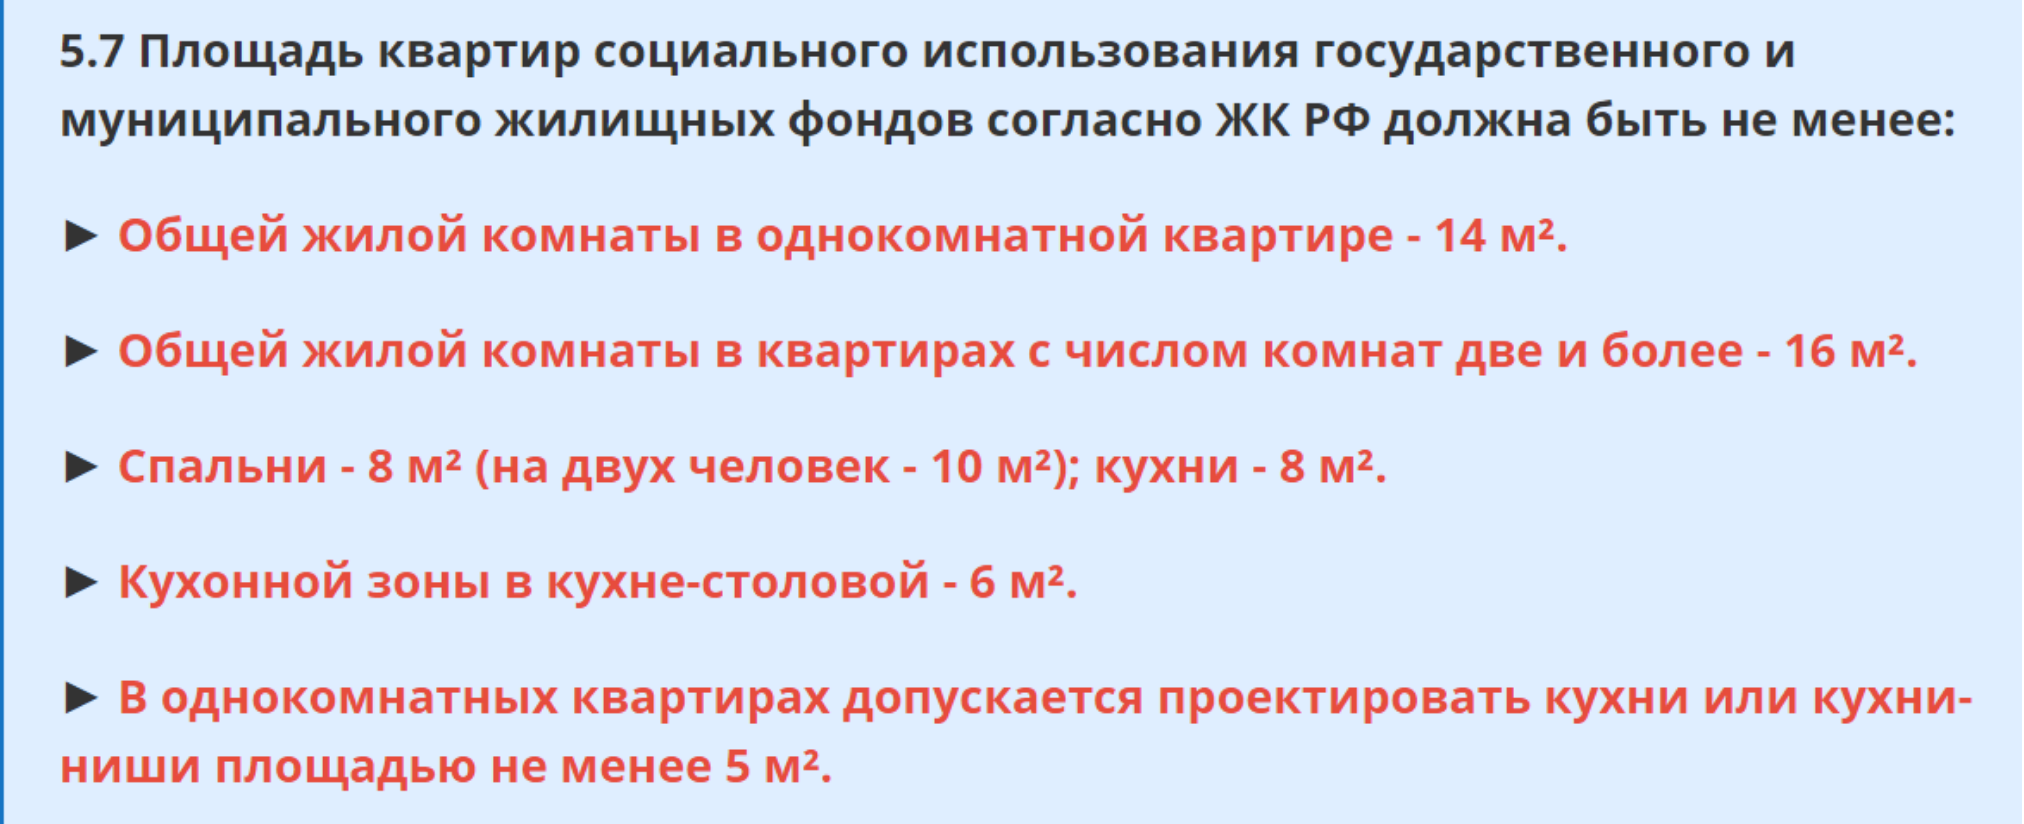

В области больших площадей наблюдения тоже неадекватные, но во первых они и должны отличаться от небольших квартир. Во-вторых если их убрать, не с чем будет сравнивать.

**KitchenSquare** 

Площадь кухни = 0 м.б. если студия. Оставляем. Медиану считаю без неадекватных значений. У меня в Новосибирске площадь кухни в двушке 18 кв. м, для Москвы 22 кв. м считаю адекватной.

In [33]:
test_df1['KitchenSquare'].value_counts()

1.0      1191
5.0       612
8.0       606
6.0       595
10.0      558
9.0       417
0.0       335
7.0       297
12.0      132
11.0      107
13.0       33
4.0        21
14.0       20
15.0       17
16.0       13
3.0        11
17.0        5
2.0         4
18.0        3
42.0        3
19.0        2
20.0        2
65.0        1
34.0        1
60.0        1
112.0       1
44.0        1
33.0        1
40.0        1
22.0        1
61.0        1
97.0        1
62.0        1
24.0        1
41.0        1
30.0        1
57.0        1
620.0       1
Name: KitchenSquare, dtype: int64

Обрабатываю неадекватные значения KitchenSquare слева.

In [34]:
list1 = list(range(1,400,5))

Обрабатываю неадекватные значения KitchenSquare слева.

In [35]:
for i in range(len(list1)-1):
  mdn=test_df1.KitchenSquare[(test_df1.Square >= list1[i-1]) & (test_df1.Square < list1[i]) & (test_df1.KitchenSquare > 5) &\
                             (test_df1.KitchenSquare <= 22)].median()
  test_df1.loc[(test_df1.Square >= list1[i-1]) & (test_df1.Square < list1[i]) & (test_df1.KitchenSquare > 0) & (test_df1.KitchenSquare <= 5),\
               'KitchenSquare'] = mdn

In [36]:
test_df1.loc[(test_df1.KitchenSquare <= 5), 'KitchenSquare'] = test_df1.KitchenSquare.median()

Обрабатываю неадекватные значения KitchenSquare справа.

In [37]:
for i in range(len(list1)-1):
  mdn=test_df1.KitchenSquare[(test_df1.Square >= list1[i-1]) & (test_df1.Square < list1[i]) & (test_df1.KitchenSquare > 5) & (test_df1.KitchenSquare <= 22)].median()
  test_df1.loc[(test_df1.Square >= list1[i-1]) & (test_df1.Square < list1[i]) & (test_df1.KitchenSquare > 22), 'KitchenSquare'] = mdn

In [38]:
test_df1.loc[(test_df1.KitchenSquare > 22), 'KitchenSquare'] = test_df1['KitchenSquare'].median()

In [39]:
test_df1.KitchenSquare.fillna(test_df1['KitchenSquare'].median(), inplace=True)

In [40]:
test_df1['KitchenSquare'].value_counts()

8.0     1662
6.0     1060
10.0     839
9.0      767
7.0      297
12.0     132
11.0     120
13.0      33
15.0      20
14.0      20
16.0      14
17.0      10
11.5       9
17.5       8
18.0       3
19.0       2
20.0       2
22.0       1
13.5       1
Name: KitchenSquare, dtype: int64

**LifeSquare**

In [41]:
test_df1['LifeSquare']=test_df1['LifeSquare'].fillna(test_df1['LifeSquare'].median())

In [42]:
test_df1['LifeSquare_outlier'] = test_df1['LifeSquare'].isna() * 1

condition = (test_df1['LifeSquare'].isna()) \
             & (~test_df1['Square'].isna()) \
             & (~test_df1['KitchenSquare'].isna())
        
test_df1.loc[condition, 'LifeSquare'] = test_df1.loc[condition, 'Square'] \
                                            - test_df1.loc[condition, 'KitchenSquare'] - 3

**HouseFloor, Floor**

In [43]:
test_df1['HouseFloor'].sort_values().unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 36., 37., 39., 40.,
       48., 99.])

In [44]:
test_df1['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 38, 46,
       78])

In [45]:
(test_df1['Floor'] > test_df1['HouseFloor']).sum()

884

In [46]:
test_df1['HouseFloor_outlier'] = 0
test_df1.loc[test_df1['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
test_df1.loc[test_df1['Floor'] > test_df1['HouseFloor'], 'HouseFloor_outlier'] = 1

In [47]:
test_df1.HouseFloor=test_df1.HouseFloor.fillna(1)

Циклом обработаю значения этажей больше этажности здания.

In [48]:
for j in range(30):
    for i in range(j, 30):
       mdn=test_df1.HouseFloor[(test_df1.Floor == i) & (test_df1.HouseFloor > j) & (test_df1.HouseFloor < 31+j)].median()
       test_df1.loc[(test_df1.Floor == i) & (test_df1.HouseFloor == j), 'HouseFloor'] = mdn

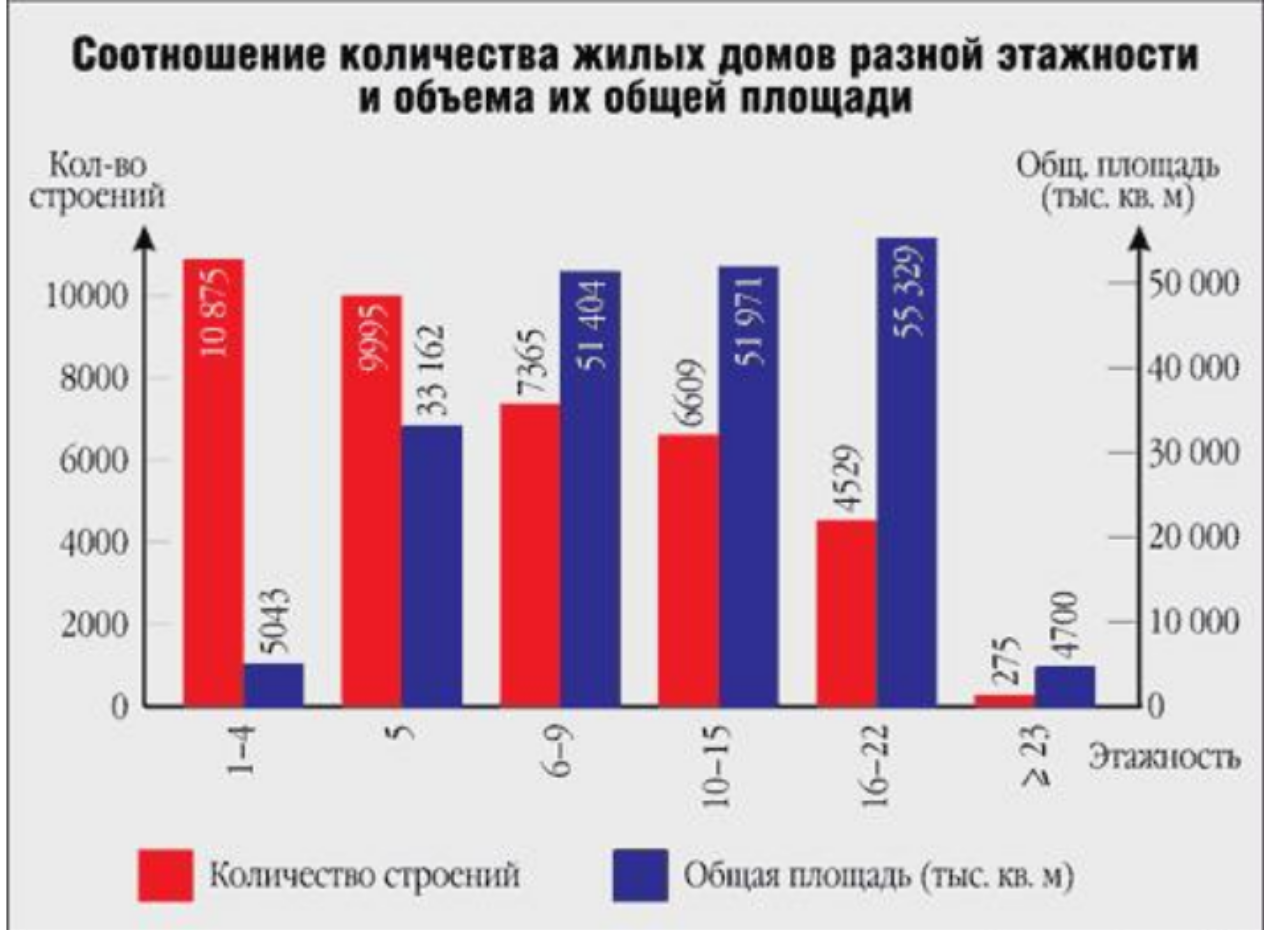

In [ ]:
Заполню предварительно пропуски самой большой модой.

In [49]:
test_df1.HouseFloor=test_df1.HouseFloor.fillna(22)                                           
test_df1.loc[(test_df1['Floor'] > test_df1['HouseFloor']), \
             'Floor'] = test_df1.loc[(test_df1['Floor'] > test_df1['HouseFloor'])]['HouseFloor']                                                                                     
test_df1.loc[test_df1.HouseFloor > 96, 'HouseFloor'] = 96  
        
test_df1.HouseFloor.fillna(test_df1['HouseFloor'].median(), inplace=True)

In [50]:
(test_df1['Floor'] > test_df1['HouseFloor']).sum()

0

**HouseYear**

In [51]:
test_df1['HouseYear'].value_counts()

1977    1298
2016     172
2015     159
2017     141
1970     111
        ... 
1910       1
1914       1
1934       1
1950       1
1908       1
Name: HouseYear, Length: 97, dtype: int64

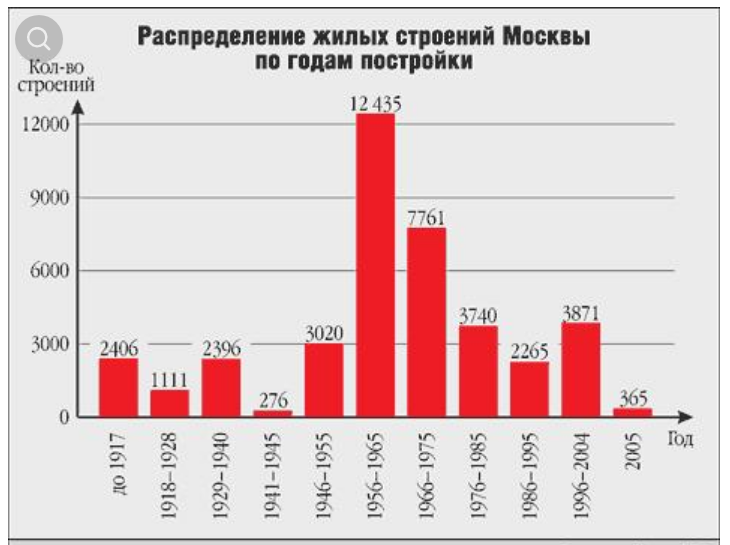

Из статистики видно, что кол-во домов 1977 года выпуска неоправданно завышено. Но попытки решения этой проблемы не привели к успеху.

In [52]:
test_df1['HouseYear_outlier'] = 0
test_df1.loc[test_df1['HouseYear'] > 2020, 'HouseYear_outlier'] = 1
#test_df1.loc[(test_df1['HouseYear'] == 1977) & (test_df1['HouseFloor'] < 18), 'HouseYear_outlier'] = 1

In [53]:
#test_df1.loc[(test_df1['HouseYear'] == 1977) & (test_df1['HouseFloor'] > 15) & (test_df1['HouseFloor'] <18), 'HouseYear'] = 1968
#test_df1.loc[(test_df1['HouseYear'] == 1977) & (test_df1['HouseFloor'] < 16), 'HouseYear'] = 1960

In [54]:
test_df1.loc[(test_df1['HouseYear'] == 1977) & (test_df1['HouseFloor'] == 16)].count()

Id                    33
DistrictId            33
Rooms                 33
Square                33
LifeSquare            33
KitchenSquare         33
Floor                 33
HouseFloor            33
HouseYear             33
Ecology_1             33
Ecology_2             33
Ecology_3             33
Social_1              33
Social_2              33
Social_3              33
Healthcare_1          17
Helthcare_2           33
Shops_1               33
Shops_2               33
Rooms_outlier         33
LifeSquare_outlier    33
HouseFloor_outlier    33
HouseYear_outlier     33
dtype: int64

In [55]:
test_df1.loc[test_df1['HouseYear'] > 2020, 'HouseYear'] = 2020

**Dummies**

In [56]:
binary_to_numbers = {'A': 1, 'B': 0}

test_df1['Ecology_2'] = test_df1['Ecology_2'].replace(binary_to_numbers)
test_df1['Ecology_3'] = test_df1['Ecology_3'].replace(binary_to_numbers)
test_df1['Shops_2'] = test_df1['Shops_2'].replace(binary_to_numbers)

**Healfcare_1**

В этой колонке нет почти половины значений. Найду их с помощью градиентного бустинга. Для деревьев стандартизация не требуется. Первым делом создаю столбец-маску для выделения Nan в столбце Healthcare_1.

# Прошу прокомментировать правильность выявлениянеадекватных значений бустингом. Есть сомнения. Для LifeSquare  тоже.

In [57]:
test_df1['Healthcare_1_nan'] = 0
test_df1.loc[test_df1['Healthcare_1'].isna(), 'Healthcare_1_nan'] = 1


обучу и проверю модель на части датасета где 'Healthcare_1_nan'=0. И найду недостающие значения 'Healthcare_1_nan' на датасете где 'Healthcare_1_nan'=1. Колонки 'Id', 'DistrictId' не имеют числового смысла, их из обработки убираю.

In [58]:
test_df1.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Rooms_outlier',
       'LifeSquare_outlier', 'HouseFloor_outlier', 'HouseYear_outlier',
       'Healthcare_1_nan'],
      dtype='object')

In [59]:
Z=test_df1[['Rooms', 'Square', 'KitchenSquare','Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1', 'Shops_2', 'Rooms_outlier',
       'HouseFloor_outlier', 'HouseYear_outlier', 'Healthcare_1_nan']][test_df1.Healthcare_1_nan==0]

In [60]:
w=test_df1['Healthcare_1'][test_df1.Healthcare_1_nan==0]
Z_train, Z_test, w_train, w_test = train_test_split(Z, w, shuffle=True, test_size=0.25)

In [61]:
#gb_model = GradientBoostingRegressor(criterion='mse',
                          #min_samples_leaf=10,
 #                         random_state=42,
                          #n_estimators=100,
                          #max_depth=7
  #                       )

In [62]:
#%%time
#params = {'n_estimators':[50, 100, 200, 400], 
 #         'max_depth':[3, 5, 7, 10],
  #        'min_samples_leaf': [3, 5, 7, 10]}

#gs = GridSearchCV(gb_model, params, 
 #                 scoring='r2', # метрика 
  #                cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
   #                        random_state=21, 
    #                       shuffle=True),
     #             n_jobs=-1
      #            )
#gs.fit(Z_train, w_train)

In [63]:
#gs.best_params_

In [64]:
final_model = GradientBoostingRegressor(criterion='mse',
                                        max_depth=7,
                                        min_samples_leaf=3,
                                        random_state=42,  
                                        n_estimators=400)
final_model.fit(Z_train, w_train)

GradientBoostingRegressor(criterion='mse', max_depth=7, min_samples_leaf=3,
                          n_estimators=400, random_state=42)

Train R2:	1.0
Test R2:	0.998


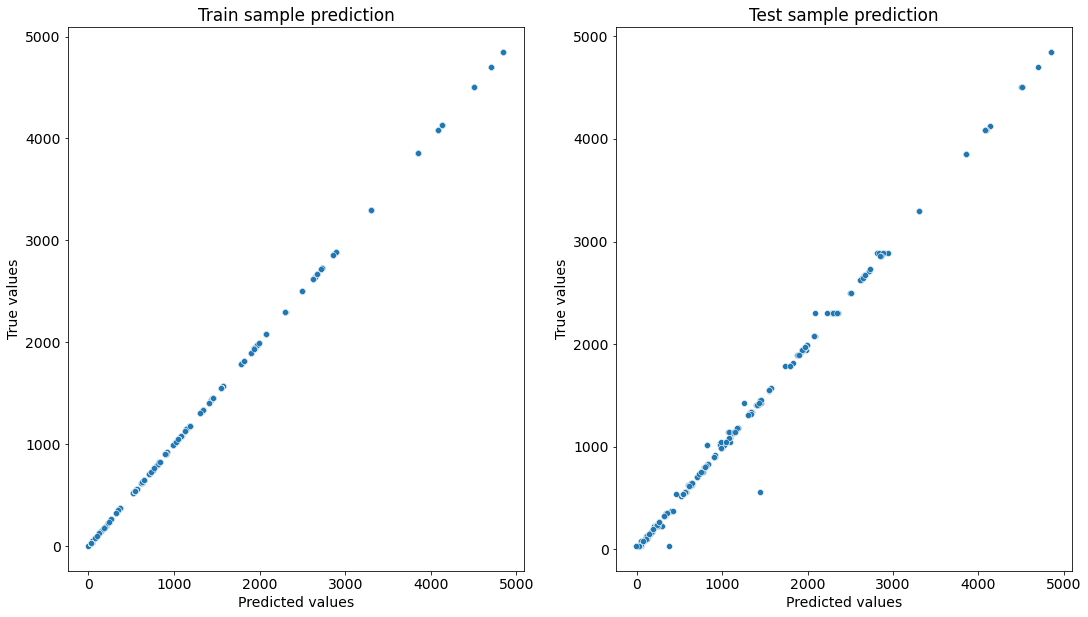

In [65]:
w_train_preds = final_model.predict(Z_train)
w_test_preds = final_model.predict(Z_test)
evaluate_preds(w_train.values, w_train_preds, w_test.values, w_test_preds)

Найду недостающие значения вместо Nan в Healthcare_1

In [66]:
test_df1[['Rooms', 'Square', 'KitchenSquare','Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1', 'Shops_2', 'Rooms_outlier',
       'HouseFloor_outlier', 'HouseYear_outlier', 'Healthcare_1_nan']][test_df1.Healthcare_1_nan==1]

,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,Healthcare_1_nan
1,1.0,42.493907,10.0,7.0,17.0,2017,0.072158,0,0,2,629,1,0,0,1,0,0,0,1
2,2.0,59.463678,9.0,19.0,22.0,1977,0.211401,0,0,9,1892,0,0,1,0,0,0,0,1
3,3.0,49.646030,6.0,2.0,9.0,1965,0.014073,0,0,2,475,0,0,0,0,0,0,0,1
6,1.0,46.269456,11.0,8.0,17.0,2014,0.072158,0,0,2,629,1,0,0,1,0,0,0,1
7,2.0,48.172969,6.0,4.0,9.0,1974,0.000000,0,0,33,7425,1,2,5,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4988,2.0,66.683295,8.0,6.0,17.0,1977,0.007122,0,0,1,264,0,0,1,0,0,0,0,1
4989,2.0,61.747208,8.0,5.0,17.0,1977,0.007122,0,0,1,264,0,0,1,0,0,0,0,1
4994,2.0,51.144906,8.0,18.0,25.0,2015,0.069753,0,0,53,13670,4,1,11,0,0,0,0,1
4995,2.0,43.177521,8.0,6.0,12.0,1962,0.069660,0,0,31,6119,4,1,2,0,0,1,0,1


In [67]:
df_HC1_Nan_preds = final_model.predict(test_df1[['Rooms', 'Square', 'KitchenSquare','Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1', 'Shops_2', 'Rooms_outlier',
       'HouseFloor_outlier', 'HouseYear_outlier', 'Healthcare_1_nan']][test_df1.Healthcare_1_nan==1])

In [68]:
test_df1['Healthcare_1'][test_df1.Healthcare_1_nan==1] = df_HC1_Nan_preds

In [69]:
test_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  5000 non-null   int64  
 1   DistrictId          5000 non-null   int64  
 2   Rooms               5000 non-null   float64
 3   Square              5000 non-null   float64
 4   LifeSquare          5000 non-null   float64
 5   KitchenSquare       5000 non-null   float64
 6   Floor               5000 non-null   float64
 7   HouseFloor          5000 non-null   float64
 8   HouseYear           5000 non-null   int64  
 9   Ecology_1           5000 non-null   float64
 10  Ecology_2           5000 non-null   int64  
 11  Ecology_3           5000 non-null   int64  
 12  Social_1            5000 non-null   int64  
 13  Social_2            5000 non-null   int64  
 14  Social_3            5000 non-null   int64  
 15  Healthcare_1        5000 non-null   float64
 16  Helthc

**LifeSquare (продолжение)**

Ищу параметры для модели предсказания неадекватных значений для признака LifeSquare

In [70]:
test_df1.loc[test_df1['LifeSquare'] < 10, 'LifeSquare_outlier'] = 1
test_df1.loc[(test_df1.Square - test_df1.KitchenSquare - test_df1.LifeSquare > 33) & (test_df1.Square < 100), \
             'LifeSquare_outlier'] = 1
test_df1.loc[((test_df1['LifeSquare']+test_df1['KitchenSquare'] + 3) / test_df1['Square'] > 1), \
             'LifeSquare_outlier'] = 1
test_df1.loc[((test_df1['LifeSquare']+test_df1['KitchenSquare'] + 3) / test_df1['Square'] > 1), \
             'LifeSquare_outlier'] = 1

Z=test_df1[['Rooms', 'Square', 'KitchenSquare','Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
    'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2', 'Rooms_outlier',
    'HouseFloor_outlier', 'HouseYear_outlier', 'Healthcare_1_nan']][test_df1.LifeSquare_outlier==0]
w=test_df1['LifeSquare'][test_df1.LifeSquare_outlier==0]
Z_train, Z_test, w_train, w_test = train_test_split(Z, w, shuffle=True, test_size=0.25)
gb_model = GradientBoostingRegressor(criterion='mse',
                          #min_samples_leaf=10,
                          random_state=42,
                          #n_estimators=100,
                          #max_depth=7
                         )
params = {'n_estimators':[50, 100, 200, 400], 
          'max_depth':[3, 5, 7, 10],
          'min_samples_leaf': [3, 5, 7, 10]}
#gs = GridSearchCV(gb_model, params, 
 #                 scoring='r2', # метрика 
  #                cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
   #                        random_state=21, 
    #                       shuffle=True),
     #             n_jobs=-1
      #            )

In [71]:
#gs.fit(Z_train, w_train)

In [72]:
#gs.best_params_

Train R2:	0.967
Test R2:	0.916


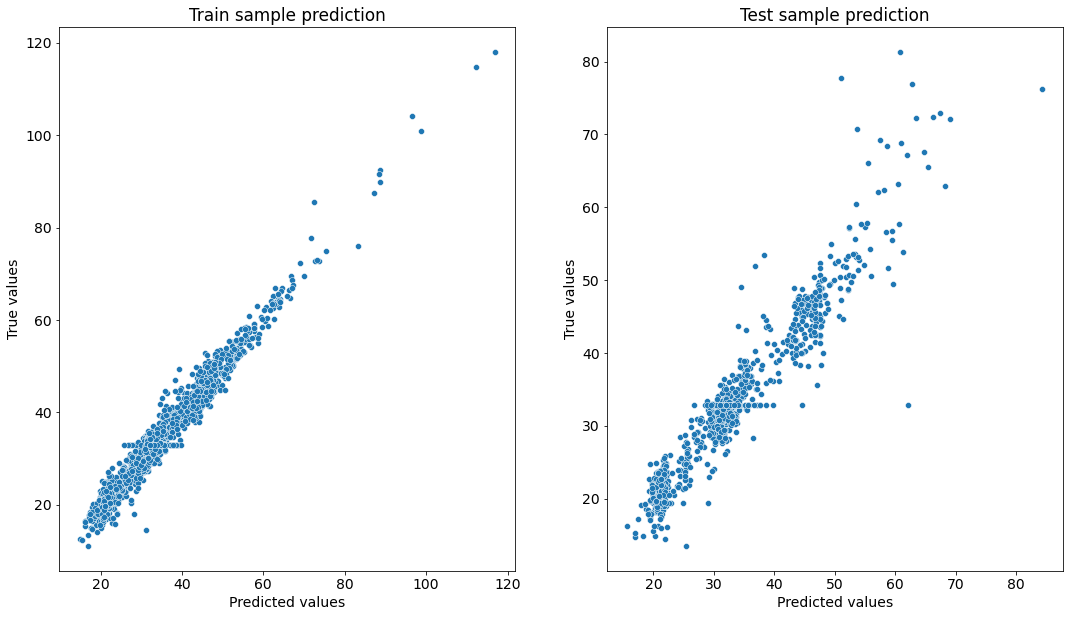

In [73]:
final_model = GradientBoostingRegressor(criterion='mse',
                                        max_depth=5,
                                        min_samples_leaf=5,
                                        random_state=42,  
                                        n_estimators=100)
final_model.fit(Z_train, w_train)
w_train_preds = final_model.predict(Z_train)
w_test_preds = final_model.predict(Z_test)
evaluate_preds(w_train.values, w_train_preds, w_test.values, w_test_preds)
df_LifeSquare_outlier_preds = final_model.predict(test_df1[['Rooms', 'Square', 'KitchenSquare','Floor', 
                                                           'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
                                                           'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 
                                                            'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2', 
                                                            'Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 
                                                            'Healthcare_1_nan']][test_df1.LifeSquare_outlier==1])
test_df1['LifeSquare'][test_df1.LifeSquare_outlier==1] = df_LifeSquare_outlier_preds

In [74]:
test_df1[['Square', 'LifeSquare', 'KitchenSquare']][test_df1['LifeSquare_outlier']==1].head()

,Square,LifeSquare,KitchenSquare
1,42.493907,21.039695,10.0
9,62.593787,35.590737,10.0
11,80.599472,45.476166,10.0
17,72.023275,37.462647,10.0
20,85.186612,52.655793,11.0


In [75]:
test_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  5000 non-null   int64  
 1   DistrictId          5000 non-null   int64  
 2   Rooms               5000 non-null   float64
 3   Square              5000 non-null   float64
 4   LifeSquare          5000 non-null   float64
 5   KitchenSquare       5000 non-null   float64
 6   Floor               5000 non-null   float64
 7   HouseFloor          5000 non-null   float64
 8   HouseYear           5000 non-null   int64  
 9   Ecology_1           5000 non-null   float64
 10  Ecology_2           5000 non-null   int64  
 11  Ecology_3           5000 non-null   int64  
 12  Social_1            5000 non-null   int64  
 13  Social_2            5000 non-null   int64  
 14  Social_3            5000 non-null   int64  
 15  Healthcare_1        5000 non-null   float64
 16  Helthc

### 3. ФУНКЦИЯ ПРЕДОБРАБОТКИ ДАННЫХ  <a class='anchor' id='nan'>

In [76]:
test_df1.isna().sum()

Id                    0
DistrictId            0
Rooms                 0
Square                0
LifeSquare            0
KitchenSquare         0
Floor                 0
HouseFloor            0
HouseYear             0
Ecology_1             0
Ecology_2             0
Ecology_3             0
Social_1              0
Social_2              0
Social_3              0
Healthcare_1          0
Helthcare_2           0
Shops_1               0
Shops_2               0
Rooms_outlier         0
LifeSquare_outlier    0
HouseFloor_outlier    0
HouseYear_outlier     0
Healthcare_1_nan      0
dtype: int64

In [77]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        self.kitchen_square_quantile = None
        self.list1 = list(range(1,400,5))
        self.list_Kitch = []
        self.list_Kitch2 = []
        self.list_Floor=[]
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)

        for i in range(len(self.list1)-1):
            mdn=X.KitchenSquare[(X.Square >= self.list1[i-1]) & (X.Square <\
                self.list1[i]) & (X.KitchenSquare > 5) & (X.KitchenSquare <= 22)].median()
            self.list_Kitch.append(mdn)
            
        for i in range(len(self.list1)-1):
            mdn2=X['KitchenSquare'][(X.Square >= self.list1[i-1]) & (X.Square < self.list1[i]) &\
                                 (X.KitchenSquare > 5) & (X.KitchenSquare <= 22)].median()
            self.list_Kitch2.append(mdn2)

        for j in range(50):
            list_r=[]
            for i in range(j, 50):
                mdn3=X['HouseFloor'][(X.Floor == i) & (X.HouseFloor > j) & (X.HouseFloor < 97)].median()
                list_r.append(mdn3)
            self.list_Floor.append(list_r)

    
    def transform(self, X):
        """Трансформация данных"""

        binary_to_numbers = {'A': 1, 'B': 0}
        X['Ecology_2'] = X['Ecology_2'].map(binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(binary_to_numbers)

        #  Square
        X['Square_outlier'] = 0
        X.loc[X['Square'] <= 10, 'Square_outlier'] = 1
        X.loc[X['Square'] <= 10, 'Square'] = self.medians['Square']
        X.Square.fillna(self.medians['Square'], inplace=True) 

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        X.loc[(X['Rooms'] == 2) & (X['Square'] < 32), 'Rooms_outlier'] = 1
        X.loc[(X['Rooms'] == 3) & (X['Square'] < 32), 'Rooms_outlier'] = 1
        X.loc[(X['Rooms'] == 4) & (X['Square'] < 32), 'Rooms_outlier'] = 1
        X.loc[(X['Rooms'] == 5) & (X['Square'] < 32), 'Rooms_outlier'] = 1
        X.loc[(X['Rooms'] == 1) & (X['Square'] > 60), 'Rooms_outlier'] = 1
        X.loc[(X['Rooms'] == 2) & (X['Square'] > 100), 'Rooms_outlier'] = 1
        X.loc[(X['Rooms'] == 3) & (X['Square'] < 43), 'Rooms_outlier'] = 1
        X.loc[(X['Rooms'] == 3) & (X['Square'] > 120), 'Rooms_outlier'] = 1
        X.loc[(X['Rooms'] == 4) & (X['Square'] < 61), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']

        X.loc[(X['Rooms'] == 2) & (X['Square'] < 32), 'Rooms'] = 1
        X.loc[(X['Rooms'] == 3) & (X['Square'] < 32), 'Rooms'] = 1
        X.loc[(X['Rooms'] == 4) & (X['Square'] < 32), 'Rooms'] = 1
        X.loc[(X['Rooms'] == 5) & (X['Square'] < 32), 'Rooms'] = 1
        X.loc[(X['Rooms'] == 1) & (X['Square'] > 60), 'Rooms'] = 2
        X.loc[(X['Rooms'] == 2) & (X['Square'] > 100), 'Rooms'] = 3
        X.loc[(X['Rooms'] == 3) & (X['Square'] < 43), 'Rooms'] = 2
        X.loc[(X['Rooms'] == 3) & (X['Square'] > 120), 'Rooms'] = 4
        X.loc[(X['Rooms'] == 4) & (X['Square'] < 61), 'Rooms'] = 3
        
        # KitchenSquare
        for i in range(len(self.list1)-1):
            X.loc[(X.Square >= self.list1[i-1]) & (X.Square < self.list1[i]) & (X.KitchenSquare > 0) &\
                  (X.KitchenSquare <= 5), 'KitchenSquare'] = self.list_Kitch[i]
                                                                                                                                                                                                                              
        X.loc[(X.KitchenSquare <= 5) & (X.KitchenSquare > 0), 'KitchenSquare'] = self.medians['KitchenSquare']
        
        for i in range(len(self.list1)-1):
            X.loc[(X.Square >= self.list1[i-1]) & (X.Square < self.list1[i]) & (X.KitchenSquare > 22),\
                  'KitchenSquare'] = self.list_Kitch2[i]                                                                                        
        
        if X.KitchenSquare[(X.KitchenSquare > 22)].count():
            X.loc[(X.KitchenSquare > 22), 'KitchenSquare'] = self.medians['KitchenSquare']                                                                                       
                                                                                                
        X.KitchenSquare.fillna(self.medians['KitchenSquare'], inplace=True) 
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
                                                   
        X.HouseFloor=X.HouseFloor.fillna(1)
        
        for j in range(50):
            for i in range(0, 50-j):
                X.loc[(X.Floor == i) & (X.HouseFloor == j) & (i > j),\
                      'HouseFloor'] = self.list_Floor[j][i]
                
        X.HouseFloor=X.HouseFloor.fillna(22)                                           
        X.loc[(X['Floor'] > X['HouseFloor']), \
             'Floor'] = X.loc[(X['Floor'] > X['HouseFloor'])]['HouseFloor']                                                                                     
        X.loc[X.HouseFloor > 96, 'HouseFloor'] = 96  
        
        X.HouseFloor.fillna(self.medians['HouseFloor'], inplace=True)
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
            
        # LifeSquare
        X['LifeSquare_outlier'] = 0
        X['LifeSquare_outlier'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3

        # Healthcare_1
        X['Healthcare_1_nan'] = 0
        X.loc[X['Healthcare_1'].isna(), 'Healthcare_1_nan'] = 1
        Z=X[['Rooms', 'Square', 'KitchenSquare','Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1', 'Shops_2', 'Rooms_outlier',
       'HouseFloor_outlier', 'HouseYear_outlier', 'Healthcare_1_nan']][X.Healthcare_1_nan==0]
        w=X['Healthcare_1'][X.Healthcare_1_nan==0]
        Z_train, Z_test, w_train, w_test = train_test_split(Z, w, shuffle=True, test_size=0.25)
        final_model = GradientBoostingRegressor(criterion='mse',
                                        max_depth=7,
                                        min_samples_leaf=3,
                                        random_state=42,  
                                        n_estimators=400)
        final_model.fit(Z_train, w_train)
        w_train_preds = final_model.predict(Z_train)
        w_test_preds = final_model.predict(Z_test)
        df_HC1_Nan_preds = final_model.predict(X[['Rooms', 'Square', 'KitchenSquare','Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1', 'Shops_2', 'Rooms_outlier',
       'HouseFloor_outlier', 'HouseYear_outlier', 'Healthcare_1_nan']][X.Healthcare_1_nan==1])
        X['Healthcare_1'][X.Healthcare_1_nan==1] = df_HC1_Nan_preds

        # LifeSquare
        X.loc[X['LifeSquare'] < 10, 'LifeSquare_outlier'] = 1
        #X.loc[(X.Square - X.KitchenSquare - X.LifeSquare > \
        #33) & (X.Square < 100), 'LifeSquare_outlier'] = 1
        X.loc[((X['LifeSquare']+X['KitchenSquare'] + \
                                   3)/X['Square'] > 1), 'LifeSquare_outlier'] = 1
        X.loc[((X['LifeSquare']+X['KitchenSquare'] + \
                                   3)/X['Square'] > 1), 'LifeSquare_outlier'] = 1

        Z=X[['Rooms', 'Square', 'KitchenSquare','Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2', 'Rooms_outlier',
       'HouseFloor_outlier', 'HouseYear_outlier', 'Healthcare_1_nan']][X.LifeSquare_outlier==0]
        w=X['LifeSquare'][X.LifeSquare_outlier==0]
        Z_train, Z_test, w_train, w_test = train_test_split(Z, w, shuffle=True, test_size=0.25)
        final_model = GradientBoostingRegressor(criterion='mse',
                                        max_depth=5,
                                        min_samples_leaf=5,
                                        random_state=42,  
                                        n_estimators=100)
        final_model.fit(Z_train, w_train)
        w_train_preds = final_model.predict(Z_train)
        w_test_preds = final_model.predict(Z_test)
        df_LifeSquare_outlier_preds = final_model.predict(X[['Rooms', 'Square', 'KitchenSquare','Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2', 'Rooms_outlier',
       'HouseFloor_outlier', 'HouseYear_outlier', 'Healthcare_1_nan']][X.LifeSquare_outlier==1])
        X['LifeSquare'][X.LifeSquare_outlier==1] = df_LifeSquare_outlier_preds


        
        
        X.fillna(self.medians, inplace=True)
        
        return X

### 4. Построение новых признаков  <a class='anchor' id='feature'>

**Dummies**

In [78]:
#binary_to_numbers = {'A': 1, 'B': 0}

#test_df1['Ecology_2'] = test_df1['Ecology_2'].replace(binary_to_numbers)
#test_df1['Ecology_3'] = test_df1['Ecology_3'].replace(binary_to_numbers)
#test_df1['Shops_2'] = test_df1['Shops_2'].replace(binary_to_numbers)

**DistrictSize, IsDistrictLarge**

In [79]:
district_size = test_df1['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,391
1,1,344
2,23,264
3,6,257
4,9,132


In [80]:
test_df1 = test_df1.merge(district_size, on='DistrictId', how='left')
test_df1.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Rooms_outlier,LifeSquare_outlier,HouseFloor_outlier,HouseYear_outlier,Healthcare_1_nan,DistrictSize
0,4567,44,1.0,36.847630,19.094182,8.0,5.0,9.0,1970,0.036122,...,1036.000000,1,1,0,0,0,0,0,0,46
1,5925,62,1.0,42.493907,21.039695,10.0,7.0,17.0,2017,0.072158,...,285.590368,0,0,1,0,1,0,0,1,122
2,960,27,2.0,59.463678,32.925087,9.0,19.0,22.0,1977,0.211401,...,476.753074,0,1,0,0,0,0,0,1,391
3,3848,23,3.0,49.646030,33.893825,6.0,2.0,9.0,1965,0.014073,...,32.407720,0,0,0,0,0,0,0,1,264
4,746,74,1.0,53.837056,32.925087,8.0,8.0,17.0,1977,0.309479,...,990.000000,0,6,0,0,0,0,0,0,61


In [81]:
(test_df1['DistrictSize'] > 100).value_counts()

False    3375
True     1625
Name: DistrictSize, dtype: int64

In [82]:
test_df1['IsDistrictLarge'] = (test_df1['DistrictSize'] > 100).astype(int)

**MedPriceDelSquareByDistrict**

In [83]:
train_df1 = train_df.copy()

In [84]:
med_price_square_by_district = train_df1.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median', 'Square':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict', 'Square': 'MedSquareByDistrict'})
med_price_square_by_district['MedPriceDelSquareByDistrict'] = med_price_square_by_district['MedPriceByDistrict'\
                                                            ] / med_price_square_by_district['MedSquareByDistrict']
med_price_square_by_district_medians = med_price_square_by_district.median()

In [85]:
train_df1 = train_df1.merge(med_price_square_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df1.fillna(med_price_square_by_district_medians, inplace=True)

ищу выбросы в Square

In [86]:
train_df1['MedPriceDelSquareByDistrict_out'] = 0

In [87]:
train_df1.loc[train_df1['MedPriceDelSquareByDistrict'] > train_df1['MedPriceDelSquareByDistrict'].quantile(.975),\
              'MedPriceDelSquareByDistrict_out'] = 1

In [88]:
train_df1.loc[train_df1['MedPriceDelSquareByDistrict'] < train_df1['MedPriceDelSquareByDistrict'].quantile(.025),\
              'MedPriceDelSquareByDistrict_out'] = 1

# ЭТОТ КОД НИЖЕ УХУДШИЛ НА 1% ТОЧНОСТЬ МОДЕЛИ! М.Б. ЕСТЬ ДРУГОЙ СПОСОБ ИЗМЕНИТЬ ЭТИ ВЫБРОСЫ?!


In [89]:

#train_df1.loc[train_df1['MedPriceDelSquareByDistrict_out'] ==\
 #                   1, 'Square'] = med_price_square_by_district_medians['MedSquareByDistrict']

In [90]:
#train_df1.loc[train_df1['MedPriceDelSquareByDistrict_out'] ==\
 #                   1, 'LifeSquare'] = train_df1.loc[train_df1['MedPriceDelSquareByDistrict_out'] ==\
  #                  1, 'Square'] - train_df1.loc[train_df1['MedPriceDelSquareByDistrict_out'] ==\
   #                 1, 'KitchenSquare'] -2

In [91]:
train_df1.loc[train_df1['MedPriceDelSquareByDistrict_out'] == 1]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,MedPriceByDistrict,MedSquareByDistrict,MedPriceDelSquareByDistrict,MedPriceDelSquareByDistrict_out
32,3876,100,4.0,104.769022,79.316650,8.0,4,8.0,1960,0.200147,...,8,770.0,2,0,B,600903.828562,548949.640224,93.568623,5866.813288,1
42,8576,4,2.0,53.179791,50.643797,5.0,5,12.0,1976,0.042032,...,84,1940.0,2,5,B,308108.233873,284278.636035,46.661064,6092.416459,1
51,12774,157,2.0,62.747509,28.196813,8.0,5,10.0,1956,0.000000,...,87,4702.0,5,5,B,555661.943969,390535.415861,48.185943,8104.758147,1
102,12734,23,3.0,79.541069,46.146407,12.0,7,17.0,2011,0.075779,...,3,NaN,0,2,B,145255.444043,166687.735824,76.950897,2166.157139,1
116,5594,23,3.0,105.479256,NaN,1.0,16,25.0,1977,0.075779,...,3,NaN,0,2,B,245260.231007,166687.735824,76.950897,2166.157139,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9927,15375,182,2.0,67.838861,65.200025,9.0,7,8.0,1918,0.015017,...,59,2890.0,0,8,B,443270.817520,443270.817520,67.838861,6534.172445,1
9955,16557,65,2.0,57.309254,34.105386,8.0,11,11.0,1957,0.081943,...,20,NaN,1,4,B,403476.612413,403476.612413,57.309254,7040.339615,1
9961,7931,181,1.0,34.911269,18.433155,6.0,10,12.0,1955,0.000000,...,37,562.0,1,8,B,397528.736061,397528.736061,34.911269,11386.831424,1
9963,12037,23,3.0,77.598316,NaN,1.0,9,25.0,1977,0.075779,...,3,NaN,0,2,B,208372.832181,166687.735824,76.950897,2166.157139,1


# MedSquareDelRoomsByHouseFloor

Этот признак создан аналогичным образом

**MedPriceByFloorYear**

In [92]:
def floor_to_cat(X):

    X['floor_cat'] = 0

    X.loc[X['Floor'] <= 3, 'floor_cat'] = 1  
    X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
    X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
    X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
    X.loc[X['Floor'] > 15, 'floor_cat'] = 5

    return X


def floor_to_cat_pandas(X):
    bins = [0, 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X


def year_to_cat(X):

    X['year_cat'] = 0

    X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
    X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
    X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
    X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
    X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
    X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

    return X


def year_to_cat_pandas(X):
    bins = [0, 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

In [93]:
bins = [0, 3, 5, 9, 15, test_df1['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins, labels=False)

0       1
1       2
2       0
3       3
4       4
       ..
9995    0
9996    3
9997    0
9998    0
9999    2
Name: Floor, Length: 10000, dtype: int64

In [94]:
bins = [0, 3, 5, 9, 15, test_df1['Floor'].max()]
pd.cut(test_df['Floor'], bins=bins)

0         (3.0, 5.0]
1         (5.0, 9.0]
2       (15.0, 46.0]
3         (0.0, 3.0]
4         (5.0, 9.0]
            ...     
4995      (5.0, 9.0]
4996    (15.0, 46.0]
4997      (0.0, 3.0]
4998      (5.0, 9.0]
4999      (5.0, 9.0]
Name: Floor, Length: 5000, dtype: category
Categories (5, interval[float64]): [(0.0, 3.0] < (3.0, 5.0] < (5.0, 9.0] < (9.0, 15.0] < (15.0, 46.0]]

In [95]:
test_df1 = year_to_cat(test_df)
test_df1 = floor_to_cat(test_df)
test_df1.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,year_cat,floor_cat
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,...,B,24,4378,0,1036.0,1,1,B,3,2
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,...,B,2,629,1,NaN,0,0,A,6,3
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,...,B,9,1892,0,NaN,0,1,B,3,5
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,...,B,2,475,0,NaN,0,0,B,3,1
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,...,B,35,7715,4,990.0,0,6,B,3,3


In [96]:
#med_price_by_floor_year = test_df1.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
 #                                           rename(columns={'Price':'MedPriceByFloorYear'})
#med_price_by_floor_year.head()

In [97]:
#test_df1 = test_df1.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
#test_df1.head()

ФУНКЦИЯ СОЗДАНИЯ НОВЫХ ПРИЗНАКОВ

In [98]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.med_price_square_by_district_medians = None
        self.med_price_by_floor_year_median = None
        self.district_size = None
        self.med_price_square_by_housefloor = None
        self.med_price_square_by_housefloor_medians = None
        self.med_price_square_by_social_2 = None
        self.med_price_square_by_social_2_medians = None
        self.med_rooms_square_by_housefloor = None
        self.med_rooms_square_by_housefloor_medians = None


        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_square_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median', 'Square':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict', 'Square': 'MedSquareByDistrict'})
            self.med_price_square_by_district['MedPriceDelSquareByDistrict'] = self.med_price_square_by_district['MedPriceByDistrict'\
                                                                          ] / self.med_price_square_by_district['MedSquareByDistrict']
            self.med_price_square_by_district_medians = self.med_price_square_by_district.median()

        ## District,, Social_2
        if y is not None:
            self.med_price_square_by_social_2 = df.groupby(['DistrictId', 'Social_2'], as_index=False).agg({'Price':'median', 'Square':'median'})\
                                            .rename(columns={'Price':'MedPriceBySocial_2', 'Square': 'MedSquareBySocial_2'})
            self.med_price_square_by_social_2['MedPriceDelSquareBySocial_2'] = self.med_price_square_by_social_2['MedPriceBySocial_2'\
                                                                          ] / self.med_price_square_by_social_2['MedSquareBySocial_2']
            self.med_price_square_by_social_2_medians = self.med_price_square_by_social_2.median()



        ## District, HouseFloor
        if y is not None:
            self.med_price_square_by_housefloor = df.groupby(['DistrictId', 'HouseFloor'], as_index=False).agg({'Price':'median', 'Square':'median'})\
                                            .rename(columns={'Price':'MedPriceByHouseFloor', 'Square': 'MedSquareByHouseFloor'})
            self.med_price_square_by_housefloor['MedPriceDelSquareByHouseFloor'] = self.med_price_square_by_housefloor['MedPriceByHouseFloor'\
                                                                          ] / self.med_price_square_by_housefloor['MedSquareByHouseFloor']
            self.med_price_square_by_housefloor_medians = self.med_price_square_by_housefloor.median()
        
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
            
        ## Rooms, HouseFloor
        self.med_rooms_square_by_housefloor = df.groupby(['DistrictId', 'HouseFloor'], as_index=False).agg({'Rooms':'median', 'Square':'median'})\
                                            .rename(columns={'Rooms':'MedRoomsByHouseFloor', 'Square': 'MedSquareByHouseFloor2'})
        self.med_rooms_square_by_housefloor['MedSquareDelRoomsByHouseFloor'] = self.med_rooms_square_by_housefloor['MedSquareByHouseFloor2'\
                                                                          ] / self.med_rooms_square_by_housefloor['MedRoomsByHouseFloor']
        self.med_rooms_square_by_housefloor_medians = self.med_rooms_square_by_housefloor.median()
        
        

        
    def transform(self, X):
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_square_by_district is not None:
            X = X.merge(self.med_price_square_by_district, on=['DistrictId', 'Rooms'], how='left')
            X.fillna(self.med_price_square_by_district_medians, inplace=True)


            X['MedPriceDelSquareByDistrict_out'] = 0
            X.loc[X['MedPriceDelSquareByDistrict'] > X['MedPriceDelSquareByDistrict'].quantile(.975),\
              'MedPriceDelSquareByDistrict_out'] = 1
            X.loc[X['MedPriceDelSquareByDistrict'] < X['MedPriceDelSquareByDistrict'].quantile(.025),\
              'MedPriceDelSquareByDistrict_out'] = 1

        ## District, HouseFloor
        if self.med_price_square_by_housefloor is not None:
            X = X.merge(self.med_price_square_by_housefloor, on=['DistrictId', 'HouseFloor'], how='left')
            X.fillna(self.med_price_square_by_housefloor_medians, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X.fillna(self.med_price_by_floor_year_median, inplace=True)

        ## District,, Social_2
        if self.med_price_square_by_social_2 is not None:
            X = X.merge(self.med_price_square_by_social_2, on=['DistrictId', 'Social_2'], how='left')
            X.fillna(self.med_price_square_by_social_2_medians, inplace=True)
            
        ## Rooms, HouseFloor
        if self.med_rooms_square_by_housefloor is not None:
            X = X.merge(self.med_rooms_square_by_housefloor, on=['DistrictId', 'HouseFloor'], how='left')
            X.fillna(self.med_rooms_square_by_housefloor_medians, inplace=True)

        return X
    
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True) 
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X
            
    

### 5. Отбор признаков  <a class='anchor' id='feature_selection'>

In [99]:
test_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'year_cat',
 'floor_cat']

In [100]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_outlier', 'DistrictSize',
                     'new_district', 'IsDistrictLarge', 'MedPriceDelSquareByDistrict', 
                     'MedSquareByDistrict', 'year_cat', 'floor_cat', 'MedPriceDelSquareByHouseFloor', 
                     'MedPriceDelSquareBySocial_2', 'MedPriceDelSquareByDistrict_out', 'MedSquareDelRoomsByHouseFloor']

target_name = 'Price'

### 6. Разбиение на train и test  <a class='anchor' id='split'>

In [101]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [102]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [103]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 25), (3300, 25), (5000, 25))

In [104]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 44), (3300, 44), (5000, 44))

In [105]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [106]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

**ПОНИЖЕНИЕ РАЗМЕРНОСТИ ДАТАФРЕЙМОВ**

In [107]:
X_train = reduce_mem_usage(X_train)

Memory usage of dataframe is 1.69 MB
Memory usage after optimization is: 0.53 MB
Decreased by 68.6%


In [108]:
X_valid = reduce_mem_usage(X_valid)

Memory usage of dataframe is 0.83 MB
Memory usage after optimization is: 0.26 MB
Decreased by 68.6%


In [109]:
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 1.26 MB
Memory usage after optimization is: 0.42 MB
Decreased by 66.7%


**СТАНДАРТИЗАЦИЯ КОЛИЧЕСТВЕННЫХ ПРИЗНАКОВ**

In [110]:
X_train.columns

Index(['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor',
       'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1',
       'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1',
       'Shops_2', 'Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier',
       'LifeSquare_outlier', 'DistrictSize', 'new_district', 'IsDistrictLarge',
       'MedPriceDelSquareByDistrict', 'MedSquareByDistrict', 'year_cat',
       'floor_cat', 'MedPriceDelSquareByHouseFloor',
       'MedPriceDelSquareBySocial_2', 'MedPriceDelSquareByDistrict_out',
       'MedSquareDelRoomsByHouseFloor'],
      dtype='object')

In [111]:
scaler = RobustScaler()

colnames = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor',
       'HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Shops_1', 'DistrictSize', 'new_district',
       'MedSquareByDistrict', 'MedPriceDelSquareByDistrict',
       'floor_cat', 'year_cat', 'MedPriceDelSquareByHouseFloor', 
       'MedPriceDelSquareBySocial_2', 'MedSquareDelRoomsByHouseFloor']
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor',
       'HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Shops_1', 'DistrictSize', 'new_district',
       'MedSquareByDistrict', 'MedPriceDelSquareByDistrict',
       'floor_cat', 'year_cat', 'MedPriceDelSquareByHouseFloor', 
       'MedPriceDelSquareBySocial_2', 'MedSquareDelRoomsByHouseFloor']]), columns=colnames)
test_df_scaled = pd.DataFrame(scaler.transform(test_df[['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor',
       'HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Shops_1', 'DistrictSize', 'new_district',
       'MedSquareByDistrict', 'MedPriceDelSquareByDistrict',
       'floor_cat', 'year_cat', 'MedPriceDelSquareByHouseFloor', 
       'MedPriceDelSquareBySocial_2', 'MedSquareDelRoomsByHouseFloor']]), columns=colnames)
X_valid_scaled = pd.DataFrame(scaler.transform(X_valid[['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor',
       'HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Shops_1', 'DistrictSize', 'new_district',
       'MedSquareByDistrict', 'MedPriceDelSquareByDistrict',
       'floor_cat', 'year_cat', 'MedPriceDelSquareByHouseFloor', 
       'MedPriceDelSquareBySocial_2', 'MedSquareDelRoomsByHouseFloor']]), columns=colnames)

ВОССОЕДИНЕНИЕ КОЛОНОК

In [112]:
X_train.columns

Index(['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor',
       'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1',
       'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1',
       'Shops_2', 'Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier',
       'LifeSquare_outlier', 'DistrictSize', 'new_district', 'IsDistrictLarge',
       'MedPriceDelSquareByDistrict', 'MedSquareByDistrict', 'year_cat',
       'floor_cat', 'MedPriceDelSquareByHouseFloor',
       'MedPriceDelSquareBySocial_2', 'MedPriceDelSquareByDistrict_out',
       'MedSquareDelRoomsByHouseFloor'],
      dtype='object')

In [113]:
X_train_union = pd.concat([X_train_scaled, X_train[['Ecology_2', 'Ecology_3', 'Shops_2', 'Helthcare_2',
       'Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'IsDistrictLarge', 'LifeSquare_outlier', 
       'MedPriceDelSquareByDistrict_out']]], axis=1)

In [114]:
X_valid_union = pd.concat([X_valid_scaled, X_valid[['Ecology_2', 'Ecology_3', 'Shops_2', 'Helthcare_2',
       'Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'IsDistrictLarge', 'LifeSquare_outlier', 
       'MedPriceDelSquareByDistrict_out']]], axis=1)

In [115]:
test_df_union = pd.concat([test_df_scaled, test_df[['Ecology_2', 'Ecology_3', 'Shops_2', 'Helthcare_2',
       'Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'IsDistrictLarge', 'LifeSquare_outlier', 
       'MedPriceDelSquareByDistrict_out']]], axis=1)

Изменения неадекватных значений признака Rooms методом ближайших соседей

# Тоже есть сомнения в правильности модели.

In [116]:
def knn_preds(X):
  # Функция обработки выбросов в Rooms

        Z=X[['Square', 'KitchenSquare','Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2',
       'HouseFloor_outlier', 'HouseYear_outlier']][X.Rooms_outlier==0]
        w=X['Rooms'][X.Rooms_outlier==0]
        Z_train, Z_test, w_train, w_test = train_test_split(Z, w, shuffle=True, test_size=0.25)
        from sklearn.neighbors import KNeighborsClassifier
        final_model = KNeighborsClassifier(n_neighbors = 5)
        final_model.fit(Z_train, w_train)
        w_train_preds = final_model.predict(Z_train)
        w_test_preds = final_model.predict(Z_test)
        df_Rooms_preds = final_model.predict(X[['Square', 'KitchenSquare','Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2',
       'HouseFloor_outlier', 'HouseYear_outlier']][X.Rooms_outlier==1])
        X['Rooms'][X.Rooms_outlier==1] = df_Rooms_preds

        return X

In [117]:
test_df_union = knn_preds(test_df_union)

In [118]:
X_valid_union = knn_preds(X_valid_union)

In [119]:
X_train_union = knn_preds(X_train_union)

In [120]:
X_train_union['Rooms'][X_train_union.Rooms_outlier==1].value_counts()

 1.0    48
 0.0    38
-1.0    10
 2.0     8
Name: Rooms, dtype: int64

In [121]:
X_train_union['Rooms'][X_train_union.Rooms_outlier==0].value_counts()

 0.0    2613
-1.0    2409
 1.0    1465
 2.0      97
 3.0      12
Name: Rooms, dtype: int64

**Построение корреляционной матрицы**

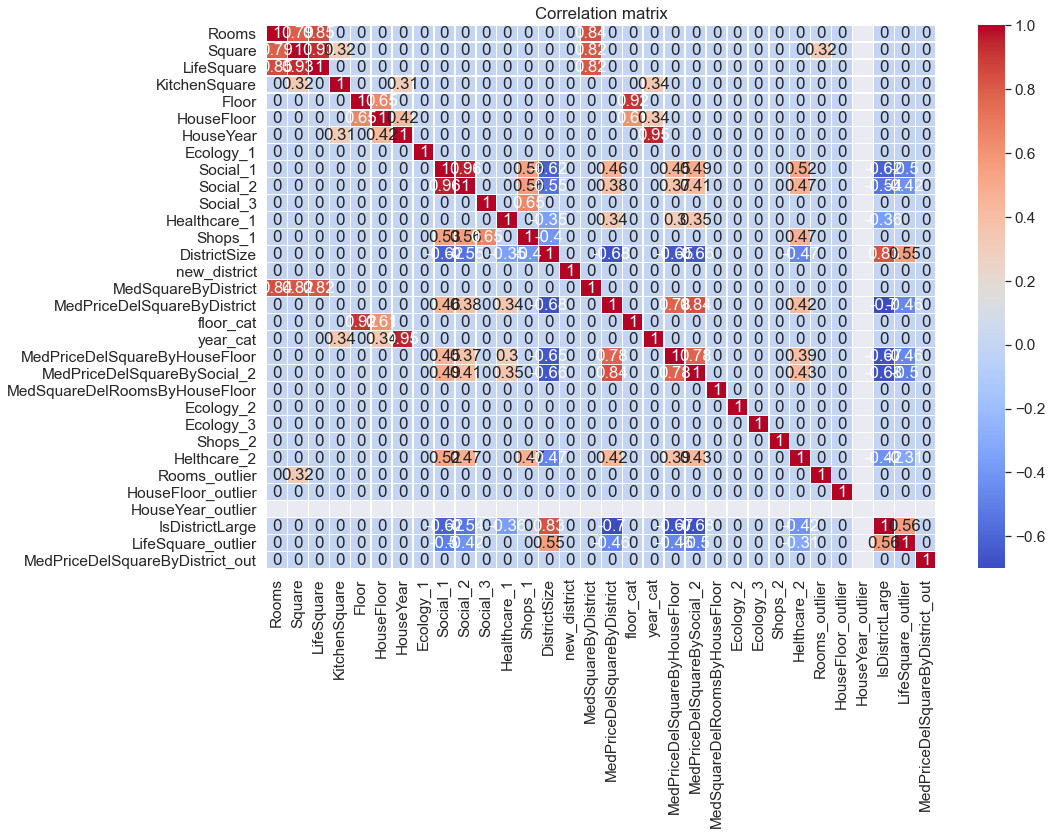

In [122]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = test_df_union.corr()
corr_matrix = np.round(corr_matrix, 2)  # округлим до 2 знаков
corr_matrix[np.abs(corr_matrix) < 0.3] = 0  # если корреляция меньше 0,3, то мы заменим на 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

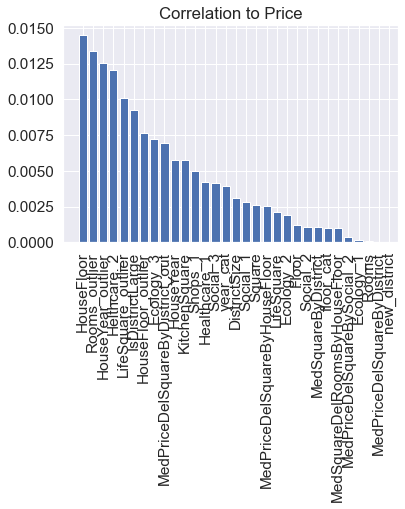

In [123]:
corrmat = X_train_union.loc[:, X_train_union.columns != 'Id'].corrwith(
    y_train).abs().sort_values(ascending=False)[1:]
plt.bar(corrmat.index, corrmat.values)
plt.title('Correlation to Price')
plt.xticks(rotation='vertical')
plt.show()

In [124]:
X_train_union.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,...,Ecology_2,Ecology_3,Shops_2,Helthcare_2,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,IsDistrictLarge,LifeSquare_outlier,MedPriceDelSquareByDistrict_out
0,-1.0,-0.388403,-0.603077,0.000000,1.375,1.125,0.000000,0.000000,-0.633333,-0.672375,...,0,0,0,0,0,0,0,1,1,0
1,1.0,1.301804,0.829546,0.666667,-0.500,0.000,0.000000,-0.424964,-0.100000,0.194478,...,0,0,0,3,0,0,0,1,1,0
2,0.0,0.041541,-0.061967,0.000000,0.875,1.000,0.074074,1.248643,-0.300000,-0.216145,...,0,0,0,1,0,1,0,0,0,0
3,0.0,-0.031295,-0.126491,-0.666667,-0.500,-0.875,-0.111111,1.062739,0.400000,0.000524,...,0,0,0,3,0,0,0,0,0,0
4,-1.0,0.049963,0.467079,-2.666667,-0.375,-0.875,0.000000,-0.020328,-0.766667,-0.813559,...,0,0,1,0,0,1,0,1,1,0


**ОБРАБОТКА ЛИНЕЙНО КОРРЕЛИРУЮЩИХСЯ ПРИЗНАКОВ МЕТОДОМ РСА**

In [125]:
def pca_features(X):
  pca = PCA(n_components=1, random_state=42)
  """Генерация новых признаков взамен коррелирующих более чем на 0,8"""
        
  # Объединение Social_1 и Social_2
  df_small = X[['Social_1', 'Social_2']]
  df_small['component_1'] = pca.fit_transform(df_small)
  X.insert(10,'Social_1_Social_2', df_small.component_1)  


  # Объединение Square u LifeSquare
  #df_small = X[['LifeSquare', 'LifeSquare']]
  #df_small['component_1'] = pca.fit_transform(df_small)
  #X.insert(10,'Square_LifeSquare', df_small.component_1) 
  
  return X

In [126]:
X_train = pca_features(X_train_union)
X_valid = pca_features(X_valid_union)
test_df = pca_features(test_df_union)
#С объединенной колонкой точность модели уменьшилась

In [127]:
X_train.drop(columns=['Social_1', 'Social_2'], axis=1, inplace=True)
X_valid.drop(columns=['Social_1', 'Social_2'], axis=1, inplace=True)
test_df.drop(columns=['Social_1', 'Social_2'], axis=1, inplace=True)

In [128]:
X_train.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1_Social_2,Social_3,...,Ecology_2,Ecology_3,Shops_2,Helthcare_2,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,IsDistrictLarge,LifeSquare_outlier,MedPriceDelSquareByDistrict_out
0,-1.0,-0.388403,-0.603077,0.000000,1.375,1.125,0.000000,0.000000,-0.929722,0.200000,...,0,0,0,0,0,0,0,1,1,0
1,1.0,1.301804,0.829546,0.666667,-0.500,0.000,0.000000,-0.424964,0.078194,27.799999,...,0,0,0,3,0,0,0,1,1,0
2,0.0,0.041541,-0.061967,0.000000,0.875,1.000,0.074074,1.248643,-0.365706,0.200000,...,0,0,0,1,0,1,0,0,0,0
3,0.0,-0.031295,-0.126491,-0.666667,-0.500,-0.875,-0.111111,1.062739,0.247349,-0.400000,...,0,0,0,3,0,0,0,0,0,0
4,-1.0,0.049963,0.467079,-2.666667,-0.375,-0.875,0.000000,-0.020328,-1.123491,-0.200000,...,0,0,1,0,0,1,0,1,1,0


### 7. Построение модели  <a class='anchor' id='modeling'>

**Обучение**

In [129]:
rf_model = RandomForestRegressor(random_state=21, criterion='mse', min_samples_leaf=10,)
rf_model.fit(X_train, y_train)

RandomForestRegressor(min_samples_leaf=10, random_state=21)

In [130]:
X_train.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1_Social_2,Social_3,...,Ecology_2,Ecology_3,Shops_2,Helthcare_2,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,IsDistrictLarge,LifeSquare_outlier,MedPriceDelSquareByDistrict_out
0,-1.0,-0.388403,-0.603077,0.000000,1.375,1.125,0.000000,0.000000,-0.929722,0.200000,...,0,0,0,0,0,0,0,1,1,0
1,1.0,1.301804,0.829546,0.666667,-0.500,0.000,0.000000,-0.424964,0.078194,27.799999,...,0,0,0,3,0,0,0,1,1,0
2,0.0,0.041541,-0.061967,0.000000,0.875,1.000,0.074074,1.248643,-0.365706,0.200000,...,0,0,0,1,0,1,0,0,0,0
3,0.0,-0.031295,-0.126491,-0.666667,-0.500,-0.875,-0.111111,1.062739,0.247349,-0.400000,...,0,0,0,3,0,0,0,0,0,0
4,-1.0,0.049963,0.467079,-2.666667,-0.375,-0.875,0.000000,-0.020328,-1.123491,-0.200000,...,0,0,1,0,0,1,0,1,1,0


In [131]:
%%time
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 10)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rs = RandomizedSearchCV(rf_model, 
                        param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)
rs.fit(X_train, y_train)
rs.best_params_
# {'n_estimators': 700,
# 'min_samples_split': 2,
# 'min_samples_leaf': 2,
# 'max_features': 'log2',
# 'max_depth': 11,
# 'bootstrap': True}

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.1min finished


CPU times: user 16.5 s, sys: 318 ms, total: 16.8 s
Wall time: 4min 24s


{'n_estimators': 1000,
 'min_samples_split': 7,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'max_depth': 15,
 'bootstrap': False}

Создам датафрейм, содержащий результаты работы алгоритма RandomizedSearchCV для того чтобы выяснить то, в каком диапазоне значений стоит продолжать поиск.

In [132]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
rs_df.head()

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,mean_test_score,rank_test_score
0,1000,7,2,log2,15,False,0.806114,1
1,400,39,2,sqrt,13,False,0.798832,2
2,1000,12,7,sqrt,15,True,0.798020,3
3,800,12,7,sqrt,11,True,0.796815,4
4,800,18,12,sqrt,13,False,0.796330,5


In [133]:
rs_df.shape

(100, 8)

Создам столбчатые графики, на которых, по оси Х, расположены значения гиперпараметров, а по оси Y — средние значения, показываемые моделями. 

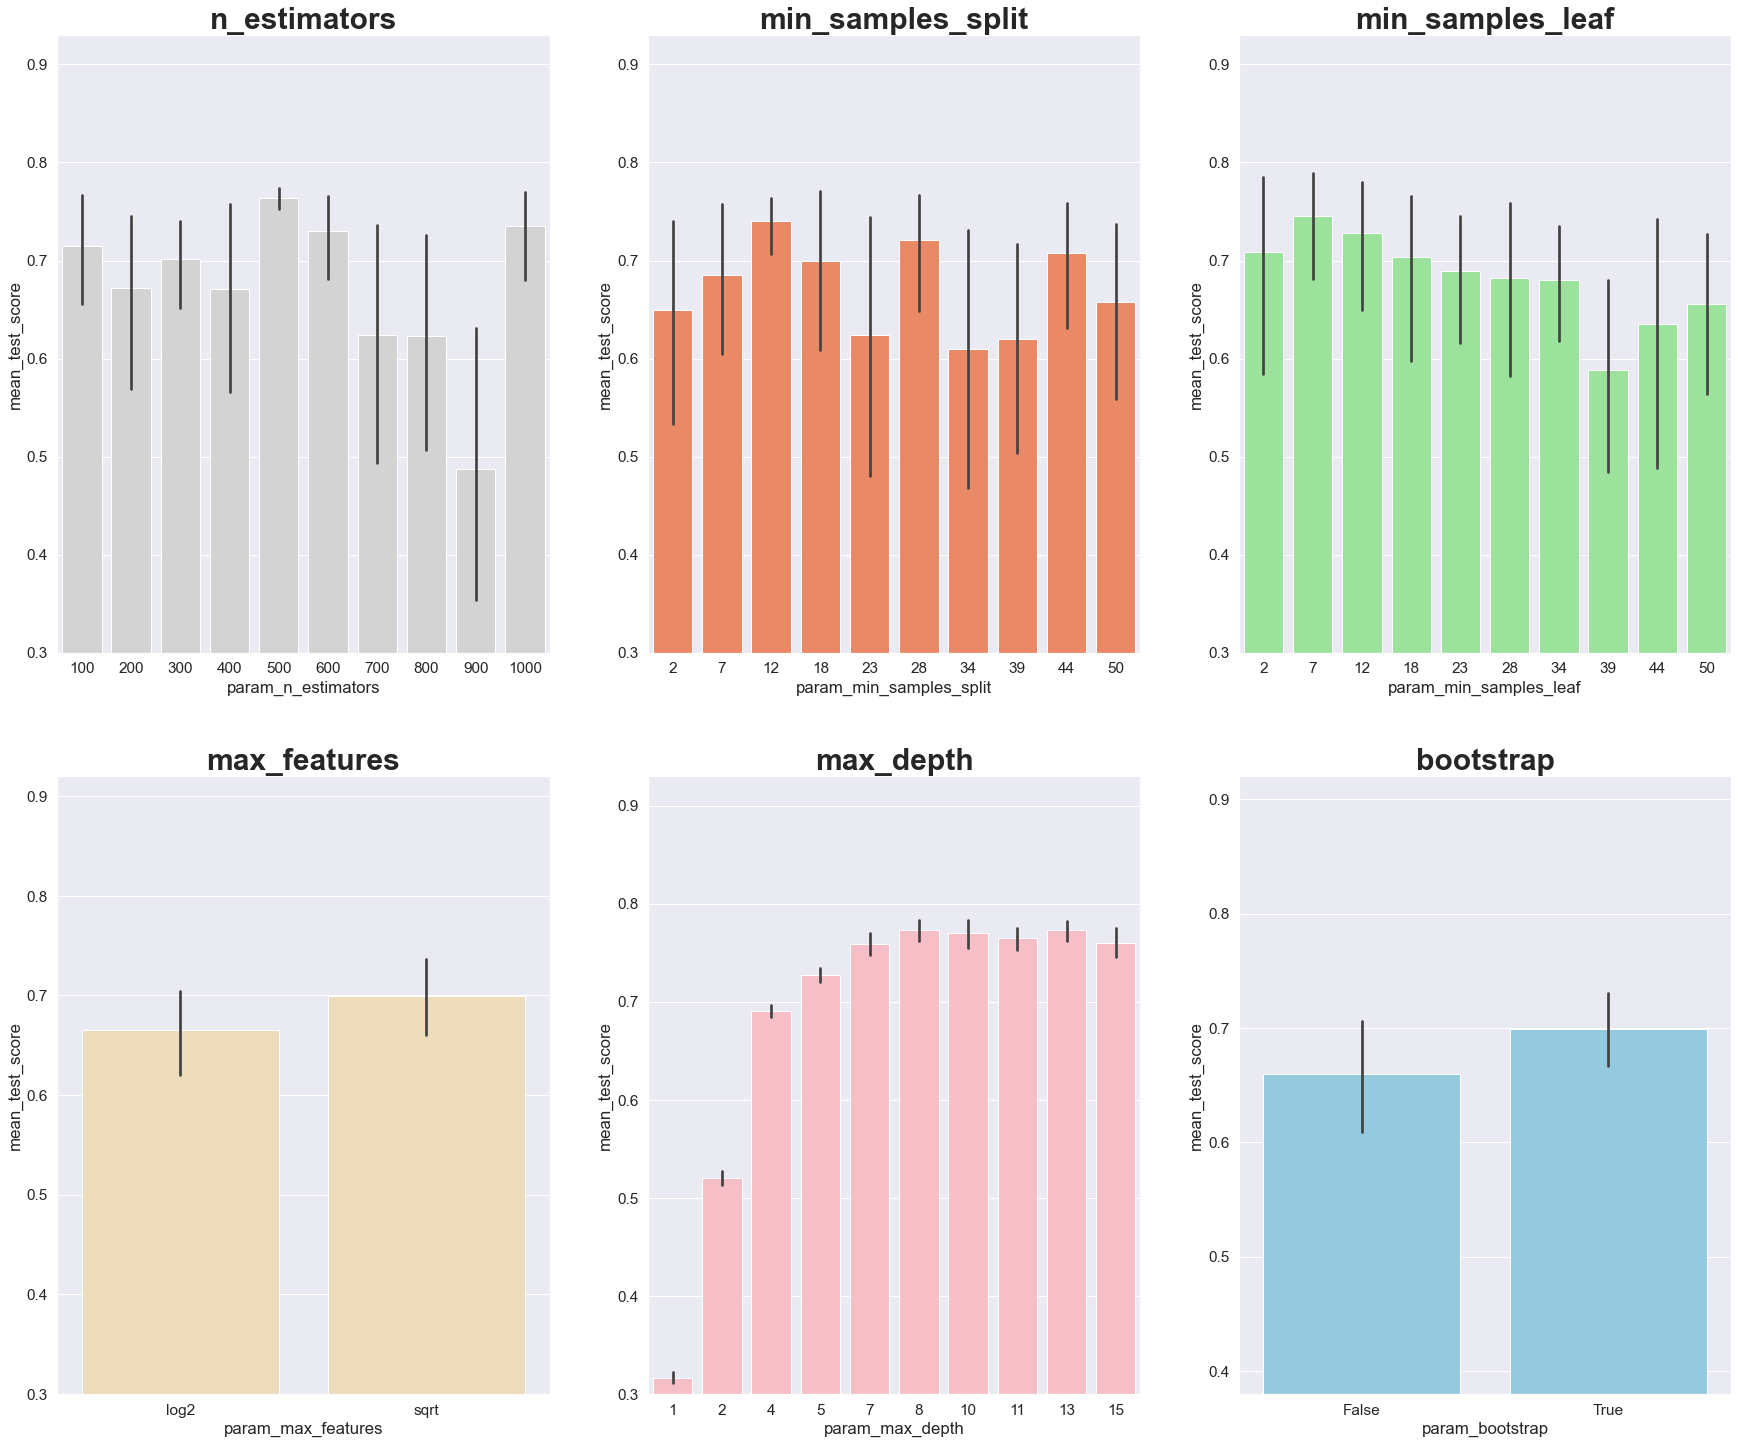

In [134]:
fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(30,25)
sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([.30,.93])
axs[0,0].set_title(label = 'n_estimators', size=30, weight='bold')
sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([.30,.93])
axs[0,1].set_title(label = 'min_samples_split', size=30, weight='bold')
sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim([.30,.93])
axs[0,2].set_title(label = 'min_samples_leaf', size=30, weight='bold')
sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
axs[1,0].set_ylim([.30,.92])
axs[1,0].set_title(label = 'max_features', size=30, weight='bold')
sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim([.30,.93])
axs[1,1].set_title(label = 'max_depth', size=30, weight='bold')
sns.barplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2], color='skyblue')
axs[1,2].set_ylim([.38,.92])
axs[1,2].set_title(label = 'bootstrap', size=30, weight='bold')
plt.show()

На основе графиков задаю значения для поиска с помощью GridSearchCV.

In [135]:
%%time
n_estimators = [500, 600, 1000]
max_features = ['sqrt']
max_depth = [8, 10, 11, 13]
min_samples_split = [12, 28]
min_samples_leaf = [6, 7, 8, 11, 12, 13]
bootstrap = [True]
parameters = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

gs = GridSearchCV(rf_model, parameters, 
                  scoring='r2', # метрика 
                  cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
                           random_state=21, 
                           shuffle=True),
                  n_jobs=-1
                  )
gs.fit(X_train, y_train)

CPU times: user 8.31 s, sys: 407 ms, total: 8.71 s
Wall time: 19min 45s


GridSearchCV(cv=KFold(n_splits=5, random_state=21, shuffle=True),
             estimator=RandomForestRegressor(min_samples_leaf=10,
                                             random_state=21),
             n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [8, 10, 11, 13],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [6, 7, 8, 11, 12, 13],
                         'min_samples_split': [12, 28],
                         'n_estimators': [500, 600, 1000]},
             scoring='r2')

In [136]:
gs.best_params_

{'bootstrap': True,
 'max_depth': 13,
 'max_features': 'sqrt',
 'min_samples_leaf': 6,
 'min_samples_split': 12,
 'n_estimators': 500}

In [137]:
gs.best_score_

0.8045817066294259

In [147]:
rf_model = RandomForestRegressor(random_state=21, criterion='mse', min_samples_leaf=6, min_samples_split = 12,\
                                 max_depth = 13,  max_features = 'sqrt', n_estimators = 500, bootstrap = 'True')
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap='True', max_depth=13, max_features='sqrt',
                      min_samples_leaf=6, min_samples_split=12,
                      n_estimators=500, random_state=21)

**Оценка модели**

Train R2:	0.877
Test R2:	0.73


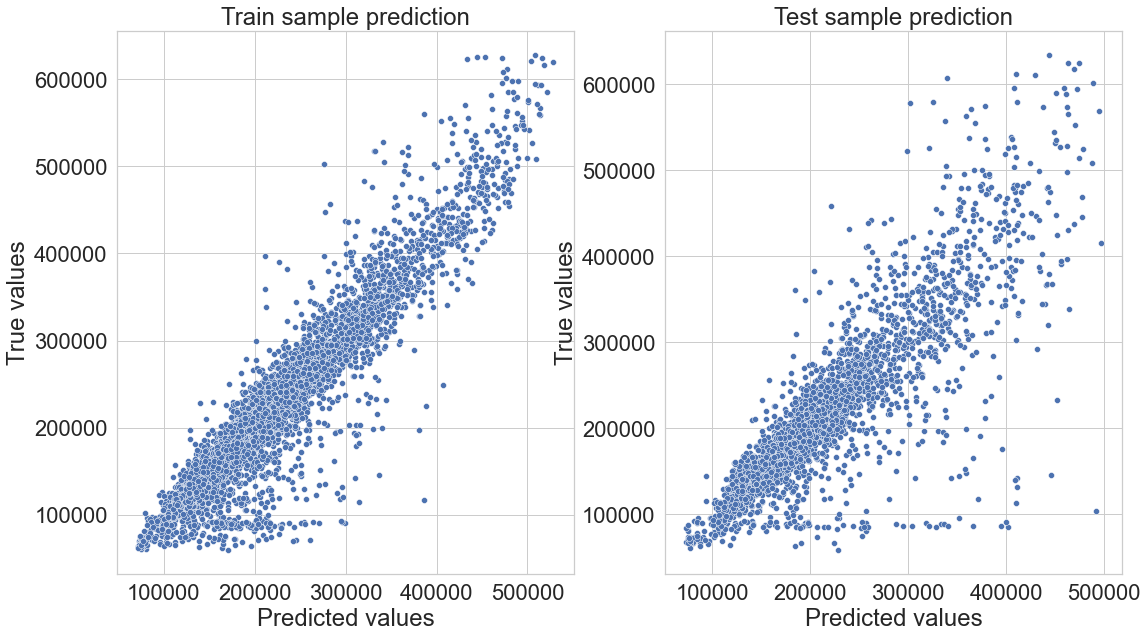

In [148]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

**Кросс-валидация**

In [149]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.81332894, 0.77664485, 0.80792575])

In [150]:
cv_score.mean()

0.799299846882203

In [151]:
cv_score2 = cross_val_score(rf_model, X_valid, y_valid, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score2

array([0.75298394, 0.70677492, 0.67963726])

In [152]:
cv_score2.mean()

0.7131320403534875

**Важность признаков**

In [153]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.176795
18,MedPriceDelSquareByHouseFloor,0.145339
2,LifeSquare,0.116101
19,MedPriceDelSquareBySocial_2,0.095640
14,MedSquareByDistrict,0.088995
0,Rooms,0.087461
15,MedPriceDelSquareByDistrict,0.075213
12,DistrictSize,0.040511
8,Social_1_Social_2,0.025009
3,KitchenSquare,0.020532


**XGBooct**

https://neerc.ifmo.ru/wiki/index.php?title=XGBoost

### 8. Прогнозирование на тестовом датасете  <a class='anchor' id='prediction'>

1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Не потерять и не перемешать индексы от примеров при построении прогнозов
3. Прогнозы должны быть для все примеров из тестового датасета (для всех строк)

In [145]:
test_df.shape

(5000, 31)

In [146]:
submit = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SKLearn_Project_Prediction/sample_submission.csv')
submit.head()

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/SKLearn_Project_Prediction/sample_submission.csv'

In [ ]:
predictions = rf_model.predict(test_df)
predictions

In [ ]:
submit['Price'] = predictions
submit.head()

In [ ]:
submit.to_csv('rf_submit.csv', index=False)